In [172]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request


In [173]:
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

### Explore Data

In [174]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [175]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [176]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


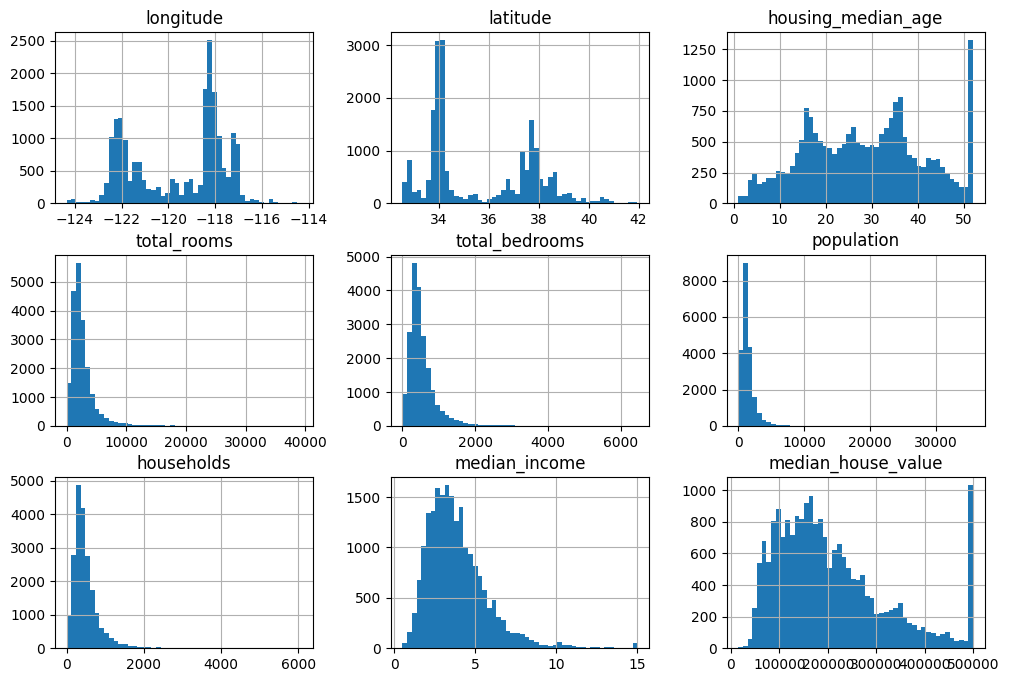

In [177]:
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(12,8))
plt.show()

### Create a training set

In [178]:
import numpy as np

np.random.seed(42)

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = shuffle_and_split_data(housing, 0.2)

In [179]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2 ** 32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [180]:
housing_with_id = housing.reset_index()
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

# use this for more stable id creation (new data might not append to bottom)
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

In [181]:
# And this is the quick way with Sklearn

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

### Stratifying the data

In [182]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0, 1.5, 3.0, 4.5, 6, np.inf],
                               labels=[1, 2, 3, 4, 5])

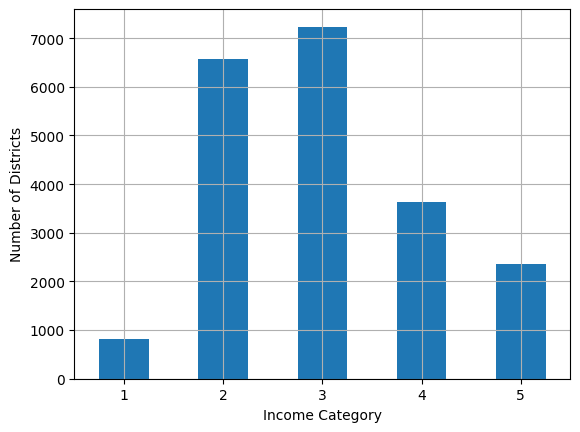

In [183]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income Category")
plt.ylabel("Number of Districts")
plt.show()

In [184]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

strat_train_set, strat_test_set = strat_splits[0]

In [185]:
# And this is the quick way

strat_test_set, strat_test_set = train_test_split(housing,
                                                  test_size=0.2,
                                                  stratify=housing["income_cat"],
                                                  random_state=42)

In [186]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [187]:
strat_train_set["income_cat"].value_counts() / len(strat_train_set)

income_cat
3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: count, dtype: float64

In [188]:
strat_train_set = strat_train_set.drop("income_cat", axis=1)
strat_test_set = strat_test_set.drop("income_cat", axis=1)

### Visualizing the data

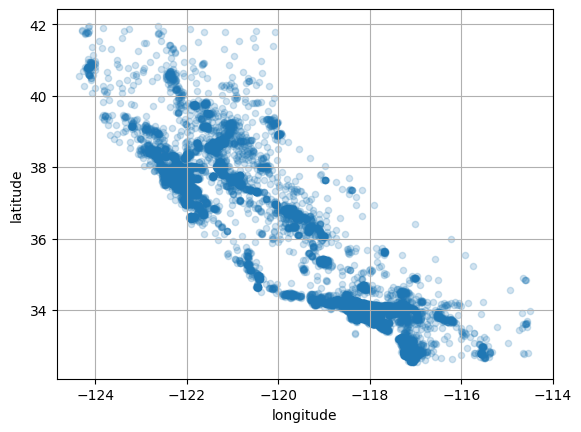

In [189]:
housing = strat_train_set.copy()

housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
plt.show()

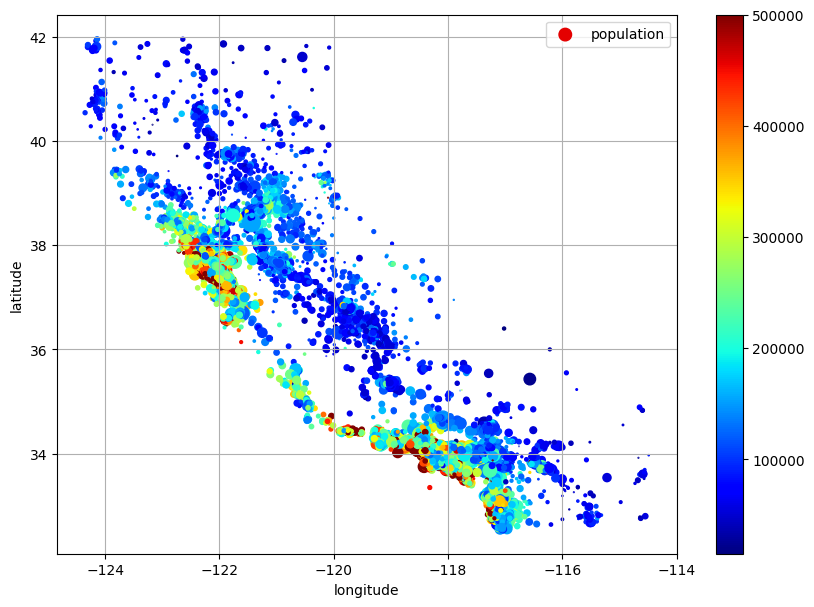

In [190]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"]/100, label="population",
             c=housing["median_house_value"], cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10,7))
plt.show()


In [191]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

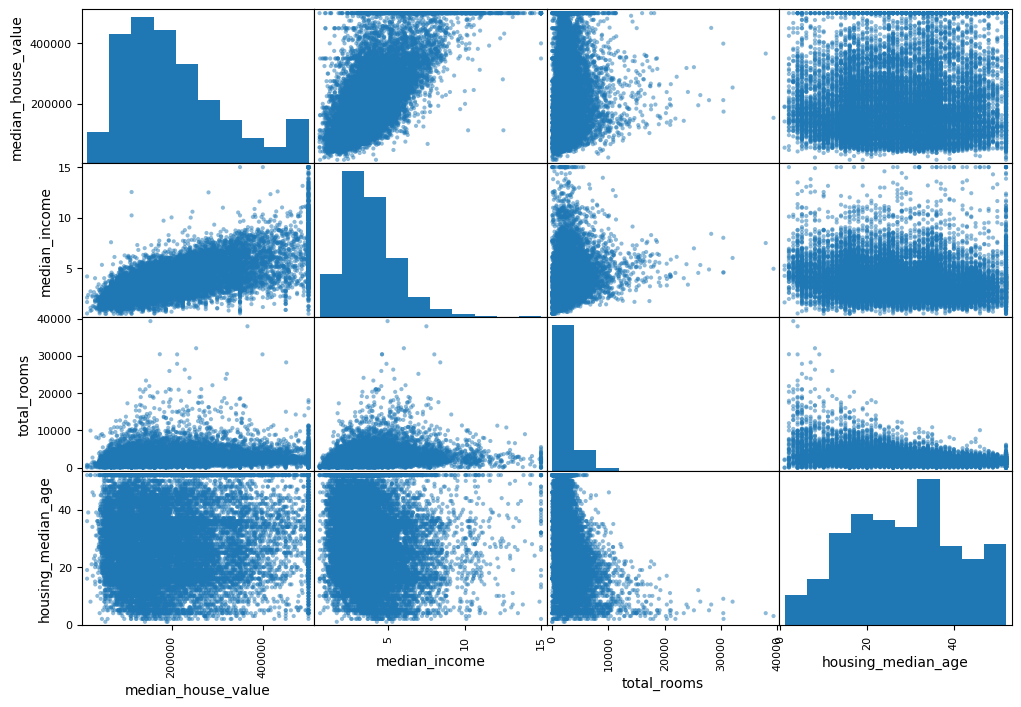

In [192]:
from pandas.plotting import scatter_matrix
housing.columns
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))
plt.show()

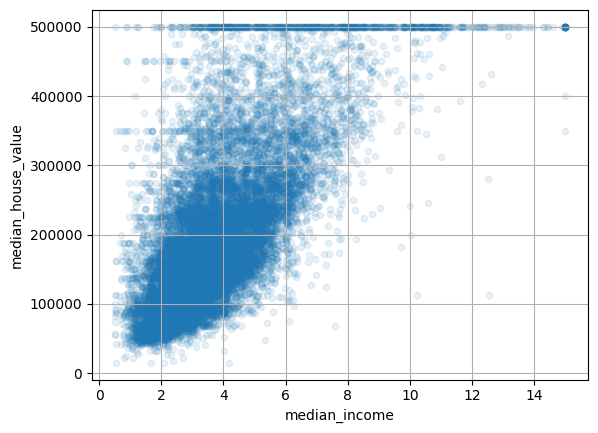

In [193]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1, grid=True)
plt.show()

### Experimenting with attribute combinatitons

In [194]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,NEAR OCEAN
...,...,...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105,500001.0,<1H OCEAN
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733,88800.0,INLAND
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616,148800.0,NEAR OCEAN
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455,500001.0,<1H OCEAN


In [195]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

## Prepare data for machine learning

In [196]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### Clean the data

In [197]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

housing_num = housing.select_dtypes(include=[np.number])

imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [198]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [199]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [200]:
X = imputer.transform(housing_num)

In [201]:
imputer.feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

In [202]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
housing_tr.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
dtype: int64

In [203]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(random_state=42)
outlier_pred = iso_forest.fit_predict(X)
outlier_pred

array([-1,  1,  1, ...,  1,  1,  1])

### text and categorical attributes

In [204]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY
18031,<1H OCEAN
6753,<1H OCEAN


In [205]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

cat_encoder.handle_unknown="ignore"

In [206]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [207]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Feature Scaling

In [208]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1,1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [209]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

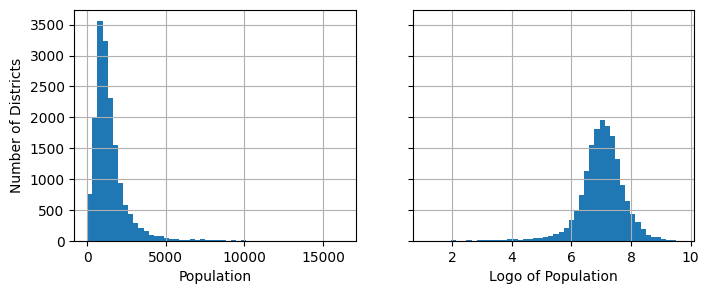

In [210]:
fig, axs = plt.subplots(1, 2, figsize=(8,3), sharey=True)
housing["population"].hist(ax=axs[0], bins=50)
housing["population"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Logo of Population")
axs[0].set_ylabel("Number of Districts")
plt.show()

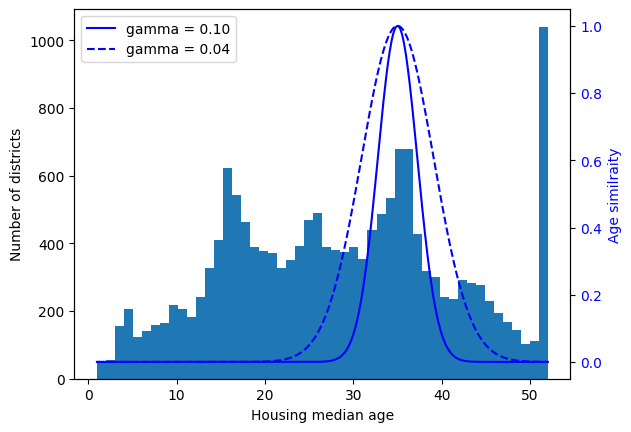

In [211]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)

ages = np.linspace(housing["housing_median_age"].min(),
                   housing["housing_median_age"].max(), 500).reshape(-1,1)

gamma1 = 0.1
gamma2 = 0.03
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2= rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(housing["housing_median_age"], bins=50)

ax2 = ax1.twinx()
color="blue"
ax2.plot(ages, rbf1, color=color, label="gamma = 0.10")
ax2.plot(ages, rbf2, color=color, label="gamma = 0.04", linestyle="--")
ax2.tick_params(axis="y", labelcolor=color)
ax2.set_ylabel("Age similraity", color=color)

plt.legend(loc="upper left")
plt.show()

In [212]:
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
dummy_new_data = housing[["median_income"]].iloc[:5]

scaled_predictions = model.predict(dummy_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)
predictions

array([[131997.15275877],
       [299359.35844434],
       [146023.37185694],
       [138840.33653057],
       [192016.61557639]])

In [213]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(),
                                   transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(dummy_new_data)
predictions

array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

### Custom Transformers

In [214]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing["population"])

In [215]:
# RBF kernel with custom functiton transformer
rbf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[0.35]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])

In [216]:
# RBF kernel with SF coordinates to show distance to SF
sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])

In [217]:
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1,2],[3,4]]))

array([[0.5 ],
       [0.75]])

In [218]:
# Custom trasnformers that have a fit() function must be created as a class

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True) -> None:
        self.with_mean = with_mean

    def fit(self, y=None): # y is required still
        X = check_array(X)  # checks that X is array with finite floats
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]    # every estimator stores this in fit()
        return self # always return self

    def transform(self, X):
        check_is_fitted(self)   # looks if it ran fit()
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_  # returns the standard scaled value

    # still needs get_feature_names_out and inverse_transform() methods

In [219]:
# More elaborate custom transformer
# This uses KMeans to create clusters, then rbf_kernel() to check distance
# against each cluster.

from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=42) -> None:
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(n_clusters=self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [220]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1, random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]],
                                           sample_weight=None)


In [221]:
similarities[:3].round(2)

array([[0.46, 0.  , 0.08, 0.  , 0.  , 0.  , 0.  , 0.98, 0.  , 0.  ],
       [0.  , 0.96, 0.  , 0.03, 0.04, 0.  , 0.  , 0.  , 0.11, 0.35],
       [0.34, 0.  , 0.45, 0.  , 0.  , 0.  , 0.01, 0.73, 0.  , 0.  ]])

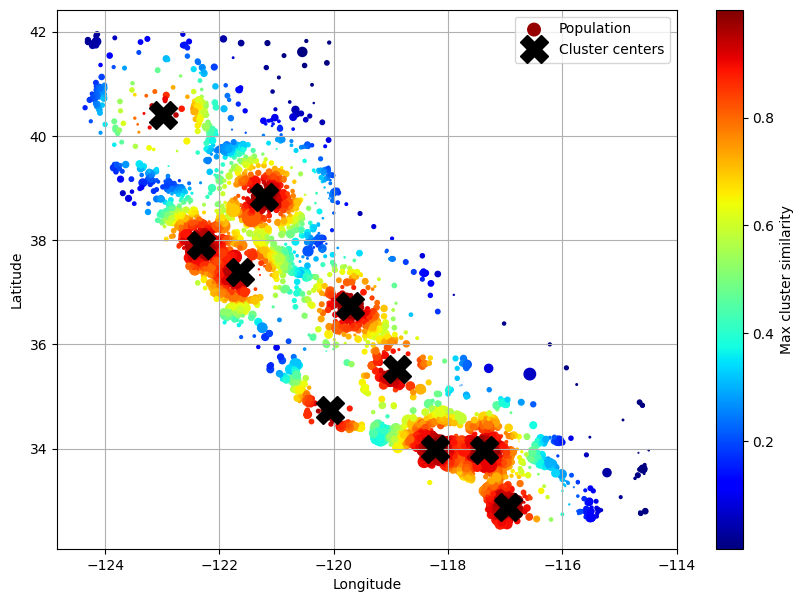

In [222]:
# plot code

housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (usᴅ)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)
housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")
plt.show()

### Transformation Pipelines

In [223]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler())
])

In [224]:
# Same as above, but instead using make_pipeline

from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())


In [225]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:5].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17],
       [-1.2 ,  1.28,  0.35, -0.71, -0.76, -0.79, -0.78, -0.76],
       [ 1.23, -0.88, -0.92,  0.7 ,  0.74,  0.38,  0.73, -0.85],
       [ 0.71, -0.88,  0.59,  0.79,  1.6 ,  0.44,  1.76, -0.18]])

In [226]:
df_housing_num_prepared = pd.DataFrame(housing_num_prepared,
                                       columns=num_pipeline.get_feature_names_out(),
                                       index=housing_num.index)

In [227]:
# add category pipeline and combine everything
# use ColumnTransformer to combine all transformers
from sklearn.compose import ColumnTransformer

num_attrs = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
             'total_bedrooms', 'population', 'households', 'median_income',
             'ocean_proximity']
cat_attrs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

preprocessing = ColumnTransformer([
    ("nums", num_pipeline, num_attrs),
    ("cats", cat_pipeline, cat_attrs),
])

# another way: make_column_selector and make_column_transformer
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)


In [228]:
housing_prepared = preprocessing.fit_transform(housing)

In [229]:
# now put everything in preprocessing together

# column ratio helper method
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio,feature_names_out=ratio_name),
        StandardScaler()
    )

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler()
)

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1, random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())

preprocessing = ColumnTransformer([
    ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
    ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
    ("people_per_house", ratio_pipeline(), ["population", "households"]),
    ("log", log_pipeline, ['total_rooms','total_bedrooms', 'population',
                             'households', 'median_income']),
    ("geo", cluster_simil, ["latitude", "longitude"]),
    ("cat", cat_pipeline, make_column_selector(dtype_include=object))
],
remainder=default_num_pipeline) # for housing_median_age


In [230]:
housing_prepared = preprocessing.fit_transform(housing)

In [231]:
housing_prepared.shape

(16512, 24)

In [232]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_rooms',
       'log__total_bedrooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

## Select and Train a model

### Train and Evaluate on the Training Set

In [233]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x131...
                                                   'population', 'households',
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(gamma=1),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x13b601c00>)])),
                ('linearregression', LinearRegression())])

In [234]:
housing_predictions = lin_reg.predict(housing)

# below are predictions, against true values underneath
housing_predictions[:5].round()

array([245970., 372738., 135707.,  91441., 330874.])

In [235]:
housing_labels[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

In [236]:
# scoring
from sklearn.metrics import mean_squared_error, root_mean_squared_error

lin_rmse = root_mean_squared_error(housing_labels, housing_predictions)
lin_rmse

68972.88910758485

In [237]:
# decision tree
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x131...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(gamma=1),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x13b601c00>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [238]:
housing_predictions = tree_reg.predict(housing)
tree_rmse = root_mean_squared_error(housing_labels, housing_predictions)
tree_rmse

0.0

In [239]:
from sklearn.model_selection import cross_val_score

tree_rmse = -cross_val_score(tree_reg, housing, housing_labels,
                            scoring="neg_root_mean_squared_error", cv=10)

In [240]:
# notice that the error is 67,000 still, not that good
pd.Series(tree_rmse).describe()

count       10.000000
mean     67438.129594
std       2373.409038
min      62994.137193
25%      66197.641972
50%      68159.370730
75%      68714.939336
max      71345.388099
dtype: float64

In [241]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels,
                                scoring="neg_root_mean_squared_error", cv=10)

In [242]:
pd.Series(forest_rmses).describe()

count       10.000000
mean     47194.393653
std       1055.384010
min      45341.598014
25%      46894.492848
50%      47285.903339
75%      47593.442538
max      49286.348685
dtype: float64

## Fine Tune Model

### Grid Search

In [243]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessinig", preprocessing),
    ("rand_forrest", RandomForestRegressor(random_state=42)),
])
param_grid = [
    {"preprocessinig__geo__n_clusters": [5, 8, 10],
     "rand_forrest__max_features": [4, 6, 8]},
    {"preprocessinig__geo__n_clusters": [10, 15],
     "rand_forrest__max_features": [6, 8, 10]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring="neg_root_mean_squared_error")
grid_search.fit(housing, housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessinig',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x13b601c00>)])),
                                       ('rand_forrest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessinig__geo__n_clusters': [5, 8, 10],
                          'rand_forrest__max_features': [4, 6, 8]},
                         {'preprocessinig__geo__n_clusters': [10, 15],
                          'rand_forrest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [244]:
grid_search.best_params_

{'preprocessinig__geo__n_clusters': 15, 'rand_forrest__max_features': 6}

In [246]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res = cv_res.sort_values(by="mean_test_score", ascending=False)
cv_res.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessinig__geo__n_clusters,param_rand_forrest__max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
12,5.496340,0.043924,0.149647,0.004766,15,6,"{'preprocessinig__geo__n_clusters': 15, 'rand_...",-43338.563554,-44187.417959,-44804.804615,-44110.262043,601.071537,1
13,6.963664,0.026779,0.143612,0.002272,15,8,"{'preprocessinig__geo__n_clusters': 15, 'rand_...",-43931.995990,-44092.241610,-44908.883049,-44311.040217,427.770736,2
14,8.492068,0.037354,0.148064,0.007269,15,10,"{'preprocessinig__geo__n_clusters': 15, 'rand_...",-44425.734676,-44676.294930,-45350.145697,-44817.391768,390.354687,3
7,5.009877,0.078722,0.131584,0.002317,10,6,"{'preprocessinig__geo__n_clusters': 10, 'rand_...",-44598.629460,-44705.122447,-45639.965557,-44981.239155,467.814453,4
9,5.054876,0.015941,0.123632,0.005214,10,6,"{'preprocessinig__geo__n_clusters': 10, 'rand_...",-44598.629460,-44705.122447,-45639.965557,-44981.239155,467.814453,4


### Randomized Search

In [248]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distributions = {"preprocessinig__geo__n_clusters": randint(low=3, high=50),
                       "rand_forrest__max_features": randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distributions, n_iter=10, cv=3,
    scoring="neg_root_mean_squared_error", random_state=42)

rnd_search.fit(housing, housing_labels)


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessinig',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names...
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x13b601c00>)])),
                                             ('rand_forrest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessinig__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x13b38a5f0>,
                                        'rand_forrest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x13bb33bb0>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [264]:
final_model = rnd_search.best_estimator_
feature_importances = final_model["rand_forrest"].feature_importances_

In [270]:
sorted(zip(feature_importances, final_model["preprocessinig"].get_feature_names_out()),
       reverse=True)

[(0.1897264081753179, 'log__median_income'),
 (0.07771005739213857, 'cat__ocean_proximity_INLAND'),
 (0.0637136109724105, 'bedrooms__ratio'),
 (0.05544031564868144, 'rooms_per_house__ratio'),
 (0.045750474737352144, 'people_per_house__ratio'),
 (0.04174369894537024, 'geo__Cluster 30 similarity'),
 (0.025193323651527245, 'geo__Cluster 36 similarity'),
 (0.02294620221735537, 'geo__Cluster 9 similarity'),
 (0.02010145402013286, 'geo__Cluster 18 similarity'),
 (0.019807327249154506, 'geo__Cluster 32 similarity'),
 (0.019047990718227773, 'geo__Cluster 25 similarity'),
 (0.01891406664742885, 'geo__Cluster 1 similarity'),
 (0.017632699006113348, 'geo__Cluster 3 similarity'),
 (0.015190735258167635, 'geo__Cluster 26 similarity'),
 (0.01359227412591622, 'geo__Cluster 34 similarity'),
 (0.013458069676517248, 'geo__Cluster 31 similarity'),
 (0.013453921667776154, 'geo__Cluster 0 similarity'),
 (0.012751867477665945, 'geo__Cluster 6 similarity'),
 (0.012689865693469294, 'geo__Cluster 19 similarity

### Evaluating System on Test Set

In [275]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = root_mean_squared_error(y_test, final_predictions)
final_rmse


41550.50174930337

In [278]:
from scipy import stats

# For 95% confidence interval
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([39358.18937491, 43632.80096861])

In [280]:
import joblib

joblib.dump(final_model, "models/california_housing_model.pkl")


['models/california_housing_model.pkl']